In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.optim as optim


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [8]:
path = './lfw'

In [9]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

torch.Size([250, 250, 3])


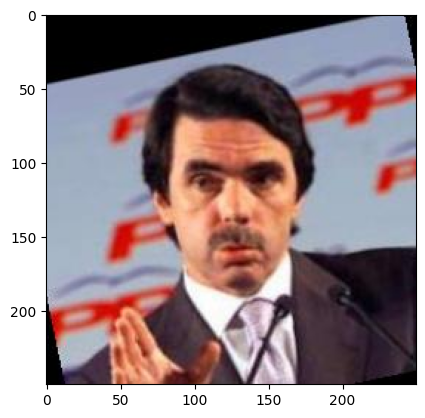

In [12]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [13]:
# Get a single batch from the dataloader
for x, y in dataloader:
    print("Batch Shape:", x.shape)  # This prints the shape of the batch
    break

Batch Shape: torch.Size([32, 3, 250, 250])


Dimensions:

32: This is the batch size. It means that in each batch, there are 32 individual images. Batch size is a parameter in machine learning that defines the number of samples to work through before updating the internal model parameters (like weights). Working with batches instead of individual samples helps in optimizing the learning process.

3: This represents the number of channels in each image. In this case, the value 3 indicates that the images are color images in the RGB (Red, Green, Blue) format. Each channel corresponds to one color intensity.

250: The first 250 represents the height of the images in pixels.

250 (second one): The second 250 represents the width of the images in pixels.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.enc_relu1 = nn.ReLU()
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size by half
        self.enc_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.enc_relu2 = nn.ReLU()

        # Decoder layers
        self.dec_upsample1 = nn.Upsample(scale_factor=2, mode='nearest')  # Upsample to [1, 32, 62, 62]
        self.dec_convtrans1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.dec_relu1 = nn.ReLU()
        self.dec_upsample2 = nn.Upsample(scale_factor=2, mode='nearest')  # Upsample to [1, 16, 124, 124]
        self.dec_convtrans2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.dec_relu2 = nn.ReLU()
        # Final upsample and convolution to get the correct size and channel count
        self.dec_upsample3 = nn.Upsample(size=(250, 250), mode='nearest')  # Resize to [1, 8, 250, 250]
        self.dec_convtrans3 = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.dec_sigmoid = nn.Sigmoid()


    def encoder(self, x):
        x = self.enc_conv1(x)
        x = self.enc_relu1(x)
        x = self.enc_pool1(x)
        x = self.enc_conv2(x)
        x = self.enc_relu2(x)
        return x

    def decoder(self, x):
        x = self.dec_upsample1(x)
        x = self.dec_convtrans1(x)
        x = self.dec_relu1(x)
        x = self.dec_upsample2(x)
        x = self.dec_convtrans2(x)
        x = self.dec_relu2(x)
        x = self.dec_upsample3(x)
        x = self.dec_convtrans3(x)
        x = self.dec_sigmoid(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [103]:
# Step 4: Create an instance of the autoencoder and pass an image from the dataloader through it
autoencoder = AE()

# Assuming you have an image tensor 'input_image' with shape [batch_size, channels, height, width]
sample_image = x[0].unsqueeze(0)  # Use the first image from the dataloader batch as an example

# Pass the image through the encoder and decoder separately
with torch.no_grad():  # Disable gradient computation
    encoded_output = autoencoder.encoder(sample_image)
    print("Encoded Output Shape:", encoded_output.shape)

    reconstructed_image = autoencoder.decoder(encoded_output)
    print("Decoded Output Shape:", reconstructed_image.shape)

Encoded Output Shape: torch.Size([1, 32, 31, 31])
Decoded Output Shape: torch.Size([1, 3, 250, 250])


The dimensions of the decoded output matches the dimensions of the original input. 
This consistency indicates that the forward path successfully reconstructs the image back to its original dimensions.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [104]:
# Assuming the AE class has been defined and an instance has been created
autoencoder = AE()

# Calculate total number of parameters
total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

# Define the loss function
loss_function = nn.MSELoss()

# Create the optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)  # You can adjust the learning rate as needed

# Print information
print("Loss Function:", loss_function)
print("Optimizer:", optimizer)


Total number of trainable parameters: 11091
Loss Function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


You would typically use this loss function during the training of your autoencoder and optimize it using an optimizer (e.g., stochastic gradient descent) to minimize the reconstruction error

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [105]:
autoencoder = autoencoder.to(device)
inputs = inputs.to(device)

num_epochs = 10  # You can adjust the number of epochs

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, _) in enumerate(dataloader):
        # Move inputs to the appropriate device (if using GPU)
        inputs = inputs.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(inputs)
        loss = loss_function(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print epoch loss
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Check if the loss is decreasing, if not, consider troubleshooting


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/functional.py:3931: UserWarning: MPS: passing scale factor to upsample ops is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/UpSample.mm:233.)
  return torch._C._nn.upsample_nearest2d(input, output_size, scale_factors)


Epoch 1/10, Loss: 0.0106
Epoch 2/10, Loss: 0.0032
Epoch 3/10, Loss: 0.0026
Epoch 4/10, Loss: 0.0024
Epoch 5/10, Loss: 0.0023
Epoch 6/10, Loss: 0.0022
Epoch 7/10, Loss: 0.0021
Epoch 8/10, Loss: 0.0020
Epoch 9/10, Loss: 0.0020
Epoch 10/10, Loss: 0.0019


If the loss is not decreasing during the training of your autoencoder, it suggests that the model is not learning effectively from the data. There are several steps you can take to troubleshoot and address this issue: Learning Rate Adjustment, Model Architecture Review, Check for Data Issues, Loss Function, Batch Size, Optimizer etc. 

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

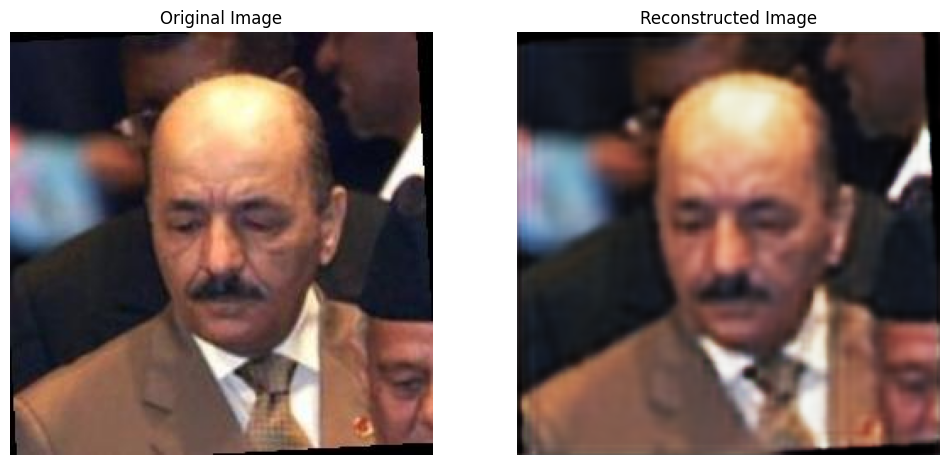

In [106]:
# Get a single batch from the dataloader
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select the first image from the batch
original_image = images[0]
original_image_np = original_image.numpy().transpose(1, 2, 0)

# Move the image to the device and add a batch dimension
input_image = original_image.unsqueeze(0).to(device)

# Pass the image through the autoencoder
with torch.no_grad():
    reconstructed = autoencoder(input_image)
    reconstructed_np = reconstructed.cpu().squeeze(0).numpy().transpose(1, 2, 0)

# Plot the original and reconstructed images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_np)
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

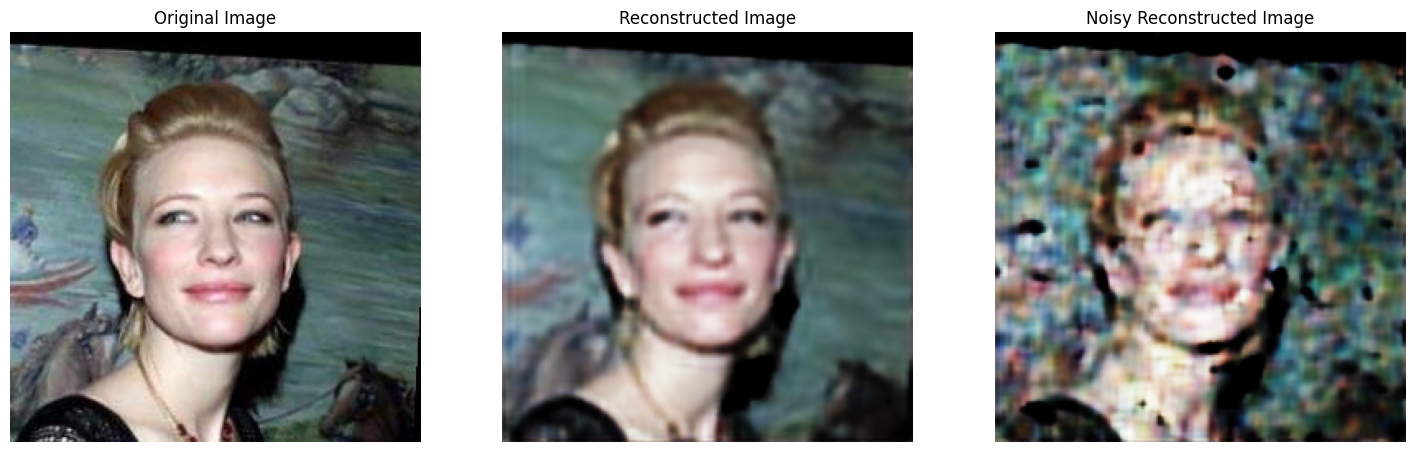

In [109]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Get a single batch from the dataloader
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select the first image from the batch
original_image = images[0]
original_image_np = original_image.numpy().transpose(1, 2, 0)

# Move the image to the device and add a batch dimension
input_image = original_image.unsqueeze(0).to(device)

# Encode the image
with torch.no_grad():
    encoded = autoencoder.encoder(input_image)

# Add small normally distributed noise to the latent representation
noise = torch.randn(encoded.shape) * 0.1  # Adjust the noise level as needed
noisy_encoded = encoded + noise.to(device)

# Decode both the original and noisy latent representation
reconstructed = autoencoder.decoder(encoded)
noisy_reconstructed = autoencoder.decoder(noisy_encoded)

# Convert to numpy for plotting (make sure to detach from the computation graph)
reconstructed_np = reconstructed.cpu().squeeze(0).detach().numpy().transpose(1, 2, 0)
noisy_reconstructed_np = noisy_reconstructed.cpu().squeeze(0).detach().numpy().transpose(1, 2, 0)

# Plot the original, reconstructed, and noisy reconstructed images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_np)
plt.title("Reconstructed Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(noisy_reconstructed_np)
plt.title("Noisy Reconstructed Image")
plt.axis('off')

plt.show()


Adding noise to the latent representation and observing the effects on the reconstructed image helps in understanding and improving the model's ability to capture and reconstruct the essential features of the input data. The degree of impact from the added noise can vary depending on the noise level, model architecture, and training procedure.